<img style="-webkit-user-select: none;margin: left;cursor: zoom-in;background-color: hsl(0, 0%, 90%);transition: background-color 300ms;" src="https://alea-auto.ru/news-raw/img/23692.php.jpg" width="640" height="480">

## Прогнозирование стоимости автомобиля по характеристикам



Задача: создать модель, предсказывающую стоимость автомобиля по его характеристикам.

По условию задачи нам необходимо собрать обучающий датасет самостоятельно. Валидационный датасет предоставлен.

Победитель определяется по метрике MAPE(Mean Percentage Absolute Error), чем меньше, тем лучше.

# Подготовка

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.base import clone
from sklearn.ensemble import StackingRegressor

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключили к ноутбуку внешний датасет
DIR_VAL   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

### Функции предобработки

In [6]:
#Вычисление целевой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

#Функция первичного осмотра данных. Вход: data - исследуемый датасет, brief_descr - краткое название датасета. Выход: void 
def first_look(data, brief_descr):
    print(brief_descr)
    print("Размерность: {}".format(data.shape))
    n = 5
    print("Первые {} строк".format(n))
    display(data.head(n))
    print("Детальная информация: ")
    data.info()
    #Проверим на пропуски
    for col in data.columns:
        if data[col].isnull().any():
            print("\n Признак {} содержит пропуски.".format(col))

# Определение min и max для числовых значений. На вход подаем имя столбца, на выходе [min,max]
def min_max(column):
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    minimum = data[column].quantile(0.25) - 1.5*IQR
    maximum = data[column].quantile(0.75) + 1.5*IQR
    return [minimum, maximum]

#кросс-валидация модели estimator, с количеством разбиений n_splits
def cv(estimator,n_splits):
    skf = KFold(n_splits=n_splits, random_state=RANDOM_SEED)

    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
        y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

         # For training, fit() is used
        estimator.fit(X_train, y_train)

        y_pred = estimator.predict(X_test)
        print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")
    
    return estimator

# 1. Сбор данных

Сбор данных реализован с помощью библиотеки Selenium. Код, представленный ниже, полностью работоспособен, но из-за того, что на сбор потребуется длительный отрезок времени в качестве обучающих данных будет использован ранее выгруженный датасет parsing-all-moscow-auto-ru-09-09-2020.

In [7]:
# from selenium import webdriver
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.common.by import By
# import time
# import requests as r
# import wget
# import gzip
# 
# #Читаем файл robots.txt с сайта https://auto.ru/robots.txt
# url = "https://auto.ru/robots.txt"
# 
# response = r.get(url)
# 
# #Получаем значение параметра Sitemap
# url = response.text[response.text.find("Sitemap"):][9:response.text[3625:].find("\n")]
# 
# response = r.get(url)
# 
# #Парсим полученный xml
# root = ET.fromstring(response.text)
# 
# #Ищем архив предложений автомобилей - архивы со строками "offers_cars", добаваляем их в массив 
# look_for_string = "offers_cars"
# offers_arc = []
# 
# for element in root:
#     if look_for_string in element[1].text: offers_arc.append(element[1].text)
#     
# #Скачиваем архивы с объявлениями
# for arc in offers_arc:
#     wget.download(arc)
# 
# #Создадим список ссылок на объявления
# pages_url_list=[]
# 
# #Открываем и читаем архивы
# for arc in offers_arc:
#     file_name = arc[arc.find("sitemap_offers_cars"):]
#     
#     with gzip.open(file_name, 'rb') as f:
#         file_content = f.read()
#     
#     #Файл внутри представляет собой XML. парсим его
#     root = ET.fromstring(file_content)
#     
#     #Ищем строки, содержашие used - авто с пробегом и добавляем их в массив ссылок
#     look_for_string = "used"
#     for element in root:
#         if look_for_string in element[0].text: pages_url_list.append(element[0].text)
# 
# #cars = итоговый, спарсенных массив данных
# cars = []
# 
# #Запускаем Selenium
# chrome_options = Options()
# driver = webdriver.Chrome(executable_path=r"chromedriver.exe",options=chrome_options)
# 
# #Открываем каждую ссылку, заносим данные в массив cars
# for url in pages_url_list:
#     driver.get(url)
#     #Определяем бренд и модель
#     elements = driver.find_elements(By.CLASS_NAME,'CardBreadcrumbs__itemText')
#     brand = elements[3].text
#     model_name = elements[4].text
# 
#     #Определяем кузов
#     element =  driver.find_elements(By.CLASS_NAME,'CardInfoRow_bodytype')
#     bodyType = element[0].text.replace("\n"," ")
# 
#     #Определяем цвет
#     element =  driver.find_elements(By.CLASS_NAME,'CardInfoRow_color')
#     color = element[0].text.replace("\n"," ").replace("Цвет ","")
# 
#     #Определяем параметры двигателя
#     element =  driver.find_elements(By.CLASS_NAME,'CardInfoRow_engine')
#     engine = element[0].text.replace("Двигатель","").split("/")
#     #Получаем значение лошадиных сил
#     engineDisplacement = engine[0][1:].replace("л ","LTR")
#     #Мощность
#     enginePower = engine[1][1:].replace("л.с. ", "N12")
#     #Тип топлива
#     fuelType = engine[2]
# 
#     #Определяем пробег
#     element =  driver.find_elements(By.CLASS_NAME,'CardInfoRow_kmAge')
#     mileage = element[0].text.replace("Пробег\n","").replace(" км","").replace(" ","")
# 
#     #Определяем год выпуска
#     element =  driver.find_elements(By.CLASS_NAME,'CardInfoRow_year')
#     productionDate = element[0].text.split("\n")[1]
# 
#     #Определяем трансмиссию
#     element = driver.find_elements(By.CLASS_NAME,'CardInfoRow_transmission')
#     vehicleTransmission = element[0].text.split("\n")[1]
# 
#     #Определяем владельца
#     element = driver.find_elements(By.CLASS_NAME,'CardInfoRow_ownersCount')
#     owners = element[0].text.split("\n")[1]
# 
#     #Определяем ПТС
#     element = driver.find_elements(By.CLASS_NAME,'CardInfoRow_pts')
#     pts = element[0].text.split("\n")[1]
# 
#     #Определяем привод
#     element = driver.find_elements(By.CLASS_NAME,'CardInfoRow_drive')
#     wd = element[0].text.split("\n")[1]
# 
#     #Определяем руль
#     element = driver.find_elements(By.CLASS_NAME,'CardInfoRow_wheel')
#     weel = element[0].text.split("\n")[1]
# 
#     #Определяем состояние
#     element = driver.find_elements(By.CLASS_NAME,'CardInfoRow_state')
#     state = element[0].text.split("\n")[1]
# 
#     #Определяем цену
#     element = driver.find_elements(By.CLASS_NAME,'OfferPriceCaption')
#     price = element[0].text[:-2:].replace(" ","")
# 
#     cars.append({"brand": brand, "model_name": model_name, "bodyType":bodyType, "color":color,\
#         "engineDisplacement":engineDisplacement,'enginePower':enginePower,"fuelType":fuelType,\
#           "mileage":mileage,"productionDate":productionDate,"vehicleTransmission":vehicleTransmission,\
#           "owners":owners,"pts":pts,"wd":wd,"weel":weel,"state":state,"price":price})
# 
#     time.sleep(1)

#### 1.1. Загрузка датасета

In [8]:
!ls '../input'

parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


In [9]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
valid = pd.read_csv(DIR_VAL+'test.csv')
sample_submission = pd.read_csv(DIR_VAL+'sample_submission.csv')

# 2. Предобработка

#### 2.1. Первичный осмотр данных

In [10]:
#Образец данных на сабмишн
first_look(sample_submission,"Образец данных на сабмишн")

Образец данных на сабмишн
Размерность: (34686, 2)
Первые 5 строк


,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0


Детальная информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


In [11]:
#Обучающий датасет
first_look(train,"Обучающий датасет")

Обучающий датасет
Размерность: (89378, 26)
Первые 5 строк


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


Детальная информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 

In [12]:
#Признаки bodyType, engineDisplacement, enginePower, modelDate, numberOfDoors, vehicleTransmission, Привод содержат только по одному пропуску. Удалим эти строки.
train.dropna(subset=['bodyType', 'enginePower', 'modelDate', 'numberOfDoors', 'vehicleTransmission', 'Привод'],inplace=True)

In [13]:
#price - целевая переменная. Строки, в которых она пропущенная, ценности не имеют. Удаляем их.
train.dropna(subset=['price'], inplace=True)

In [14]:
#Валидационный датасет
first_look(valid,"Валидационный датасет")

Валидационный датасет
Размерность: (34686, 32)
Первые 5 строк


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


Детальная информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name         

Много признаков содержат пропуски. В дальнейшем необходимо будет определить важные признаки и заполнить в них пропуски.

In [15]:
#Признак наименования модели в обучающем и валидационном датасэте имеет разные названия: model - в обучающем, model_name - в валидационном. 
#Сделаем все как в валидационнм.

train = train.rename(columns = {"model": "model_name"})

In [16]:
#В валидационном датасете признак parsing_unixtime указан в виде unix-метки, переведем значение YYYY-mm-dd
valid['parsing_unixtime'] = pd.to_datetime(valid['parsing_unixtime'],unit='s').dt.date.astype('str')

In [17]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и валидация в один датасет
train['sample'] = 1 # помечаем где у нас трейн
train.reset_index(inplace=True,drop=True)

valid['sample'] = 0  # помечаем где у нас валидация

#Целевая переменная в обучающем датасете
y = train['price']

data = valid.append(train.drop(columns=['price']), sort=False).reset_index(drop=True) # объединяем

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123653 entries, 0 to 123652
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              123653 non-null  object 
 1   brand                 123653 non-null  object 
 2   car_url               34686 non-null   object 
 3   color                 123653 non-null  object 
 4   complectation_dict    6418 non-null    object 
 5   description           120419 non-null  object 
 6   engineDisplacement    123653 non-null  object 
 7   enginePower           123653 non-null  object 
 8   equipment_dict        24690 non-null   object 
 9   fuelType              123653 non-null  object 
 10  image                 34686 non-null   object 
 11  mileage               123653 non-null  int64  
 12  modelDate             123653 non-null  float64
 13  model_info            34686 non-null   object 
 14  model_name            123653 non-null  object 
 15  

#### 2.2. Краткое описание признаков

- bodyType - тип кузова
- brand - марка авто
- car_url - ссылка на объявление
- color - цвет
- complectation_dict - комплектация
- description - описание и реклама
- engineDisplacement - объем двигателя
- enginePower - мощность двигателя 
- equipment_dict - словарь установленного оборудования
- fuelType - тип топлива
- image - ссылка на картинку авто
- mileage - пробег
- modelDate - год модели
- model_info - словарь описания модели
- model_name - имя модели
- name - краткое описание двигателя и мощности
- numberOfDoors - количество дверей
- parsing_unixtime - время сбора данных
- priceCurrency - валюта, в которой указывалась цена
- productionDate - дата выпуска авто
- sell_id - идентифиактор объявления
- super_gen - описание характеристик авто
- vehicleConfiguration - краткое описание привода, кузова и объема двигателя
- vehicleTransmission - тип коробки передач 
- vendor - регион производства авто
- Владельцы - количество владельцев 
- Владение - срок владения 
- ПТС - оригинал/дубликат
- Привод - привод)
- Руль - расположение рулевого колеса
- Состояние - состояние авто на момент подачи объявления
- Таможня - авто растаможено в РФ или нет
- Комплектация - словарь с описанием комплектации
- start_date - дата подачи объявления
- hidden - пустой признак в тренировочном датасете

#### 2.3. Удаление неинформативных признаков.

Часть признаков не несет никакой полезной информации или содержит дублирующую. Удаляем их. Также удаялем признаки с большим количеством пропусков.

In [19]:
data.drop(columns=['car_url','complectation_dict','description','equipment_dict','image','model_info','name','priceCurrency','sell_id','super_gen','vehicleConfiguration',\
                   'vendor','Комплектация','hidden','Владение','Состояние','Таможня','engineDisplacement','start_date'],inplace=True)

In [20]:
first_look(data,"Объединненый датасет")

Объединненый датасет
Размерность: (123653, 17)
Первые 5 строк


,bodyType,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,sample
0,лифтбек,SKODA,синий,105 N12,бензин,74000,2013.0,OCTAVIA,5.0,2020-10-20,2014,роботизированная,3 или более,Оригинал,передний,Левый,0
1,лифтбек,SKODA,чёрный,110 N12,бензин,60563,2017.0,OCTAVIA,5.0,2020-10-20,2017,механическая,1 владелец,Оригинал,передний,Левый,0
2,лифтбек,SKODA,серый,152 N12,бензин,88000,2013.0,SUPERB,5.0,2020-10-20,2014,роботизированная,1 владелец,Оригинал,передний,Левый,0
3,лифтбек,SKODA,коричневый,110 N12,бензин,95000,2013.0,OCTAVIA,5.0,2020-10-20,2014,автоматическая,1 владелец,Оригинал,передний,Левый,0
4,лифтбек,SKODA,белый,152 N12,бензин,58536,2008.0,OCTAVIA,5.0,2020-10-20,2012,автоматическая,1 владелец,Оригинал,передний,Левый,0


Детальная информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123653 entries, 0 to 123652
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123653 non-null  object 
 1   brand                123653 non-null  object 
 2   color                123653 non-null  object 
 3   enginePower          123653 non-null  object 
 4   fuelType             123653 non-null  object 
 5   mileage              123653 non-null  int64  
 6   modelDate            123653 non-null  float64
 7   model_name           123653 non-null  object 
 8   numberOfDoors        123653 non-null  float64
 9   parsing_unixtime     34686 non-null   object 
 10  productionDate       123653 non-null  int64  
 11  vehicleTransmission  123653 non-null  object 
 12  Владельцы            110084 non-null  object 
 13  ПТС                  123291 non-null  object 
 14  Привод               123653 non-null  object 

#### 2.4. Заполнение пропусков

Заполним пропуски в признаках Владельцы и ПТС значением NOINFO. Отсутствие данных о количестве владельцев и птс зачастую означает, что автомобиль проблемный. Отдельное значение по этим категориям (а не среднее или наиболее часто встречающееся) будет хорошим маркером.

In [21]:
data.fillna("NOINFO",inplace=True)

In [22]:
#Переименуем признаки, содержащие кириллицу и выведем информацию по получившемуся датасету
data = data.rename(columns = {'Владельцы':'owners','ПТС':'pts','Привод':'wd','Руль':'wheel'})
first_look(data,'Датасет без пропусков')

Датасет без пропусков
Размерность: (123653, 17)
Первые 5 строк


,bodyType,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,vehicleTransmission,owners,pts,wd,wheel,sample
0,лифтбек,SKODA,синий,105 N12,бензин,74000,2013.0,OCTAVIA,5.0,2020-10-20,2014,роботизированная,3 или более,Оригинал,передний,Левый,0
1,лифтбек,SKODA,чёрный,110 N12,бензин,60563,2017.0,OCTAVIA,5.0,2020-10-20,2017,механическая,1 владелец,Оригинал,передний,Левый,0
2,лифтбек,SKODA,серый,152 N12,бензин,88000,2013.0,SUPERB,5.0,2020-10-20,2014,роботизированная,1 владелец,Оригинал,передний,Левый,0
3,лифтбек,SKODA,коричневый,110 N12,бензин,95000,2013.0,OCTAVIA,5.0,2020-10-20,2014,автоматическая,1 владелец,Оригинал,передний,Левый,0
4,лифтбек,SKODA,белый,152 N12,бензин,58536,2008.0,OCTAVIA,5.0,2020-10-20,2012,автоматическая,1 владелец,Оригинал,передний,Левый,0


Детальная информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123653 entries, 0 to 123652
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123653 non-null  object 
 1   brand                123653 non-null  object 
 2   color                123653 non-null  object 
 3   enginePower          123653 non-null  object 
 4   fuelType             123653 non-null  object 
 5   mileage              123653 non-null  int64  
 6   modelDate            123653 non-null  float64
 7   model_name           123653 non-null  object 
 8   numberOfDoors        123653 non-null  float64
 9   parsing_unixtime     123653 non-null  object 
 10  productionDate       123653 non-null  int64  
 11  vehicleTransmission  123653 non-null  object 
 12  owners               123653 non-null  object 
 13  pts                  123653 non-null  object 
 14  wd                   123653 non-null  object 

#### 2.5. Очистка данных
Категориальные признаки: bodyType, brand, color, fuelType, model_name, vehicleTransmission, pts, wd.

Бинарные признаки: wheel, customs.

Количественные признаки: engineDisplacement, enginePower, mileage, modelDate, numberOfDoors, productionDate, owners.

In [23]:
#Бинарные категориальные переменные
bin_cols = ['wheel']

#Количественные переменные
num_cols = ['enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'owners']

#Категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'pts', 'wd']

##### 2.5.1. Бинарные переменные

In [24]:
#Посмотрим на значения в бинарных переменных
for col in bin_cols:
    print(col)
    print(data[col].value_counts())
    print("#"*20)

wheel
LEFT      87185
Левый     33287
RIGHT      1782
Правый     1399
Name: wheel, dtype: int64
####################


In [25]:
#Значения различаются, заменим значения на цифровые LEFT, Левый = 0, RIGHT, Правый = 1 (Можно было использовать LabelEncoder, но раз все равно будем заменять часть, пройдем сразу по всему признаку)
data['wheel'].replace({"LEFT":0,"Левый":0,"RIGHT":1,"Правый":1},inplace=True)

##### 2.5.2 Категориальные переменные

In [26]:
#Посмотрим на значения в категориальных переменных
for col in cat_cols:
    print(col)
    print(data[col].unique())
    print(data[col].dtypes)
    print("#"*20)

bodyType
['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'Седан' 'Универсал 5 дв.'
 'Хэтчбек 5 дв. Sportback' 'Хэтчбек 3 дв.' 'Хэтчбек 5 дв.' 'Кабриолет'
 'Купе' 'Лифтбек Sportback' 'Лифтбек' 'Седан Long' 'Внедорожник 5 дв.'
 'Кабриолет Roadster' 'Седан 2 дв.' 'Седан Gran Coupe' 'Компактвэн'
 'Компактвэн Gran Tourer' 'Лифтбек Gran Turismo' 'Хэтчбек 3 дв. Compact'
 'Лифтбек Gran Coupe' 'Купе-хардтоп' 'Родстер Roadster' 'Родстер'
 'Внедорожник 5 дв. ESV' 'Минивэн' 'Пикап Двойная кабина'
 'Внедорожник 3 дв.' 'Пикап Одинарная кабина' 'Тарга'
 'Пикап Двойная кабина Crew Cab' 'Пикап Двойная кабина Double'
 'Пикап Одинарная кабина Regular Cab' 'Внедорожник 5 дв. EXT' 'Седан SRT8'
 'Минивэн 

C признаком bodyType все плохо. Слишком много различающихся значений. Причем бОльшая часть различающихся пришло из обучающего датасета.

Заменим длинные значения из обучающего датасэта на более короткие из валидационного. Например "Пикап Двойная кабина Raptor CrewCab" -> "пикап двойная кабина"

In [27]:
#получаем список "правильных" значений
corr_body_list = data[data['sample'] == 0]['bodyType'].sort_values(ascending=False).unique()

#value - проверяемое занчение Возвращает исправленное значение, если сопоставил его со списком, иначе оставляет как есть.
def replace_long_value(value):
    #проходим по списку "правильных" значений и ищем совпадение в проверяемой строке
    for corr_val in corr_body_list:
        if corr_val in value.lower(): return corr_val
    #если ничего не нашли, возвращаем оригинал
    return value.lower()

In [28]:
data['bodyType'] = data['bodyType'].apply(replace_long_value)

In [29]:
#в признаке color содержатся как русскоязычные наименования цветов, так и RGB. Приведем все к виду русскоязычных наименований.
#создадим словарь
color_dict = {'040001':"чёрный", 'EE1D19': 'красный', '0000CC':'синий', 'CACECB':'серебристый',\
              '007F00':'зелёный', 'FAFBFB':'белый', '97948F':'серый', '22A0F8':'голубой',\
              '660099':'пурпурный', '200204':'коричневый', 'C49648':'бежевый',\
              'DEA522':'золотистый','4A2197':'фиолетовый', 'FFD600':'жёлтый',\
              'FF8649':'оранжевый', 'FFC0CB':'розовый'}

data['color'].replace(color_dict,inplace=True)

In [30]:
#В признаке vehicleTransmission содержатся названия типов трансмиссий как на русском, так и на английском, приведем к русскому.
trans_dict = {'MECHANICAL': 'механическая','AUTOMATIC':'автоматическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'}
data['vehicleTransmission'].replace(trans_dict,inplace=True)

#В признаке pts содержатся значения как на русском, так и на английском, приведем к русскому
pts_dict = {'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}
data['pts'].replace(pts_dict,inplace=True)

In [31]:
#Признак model_name содержит большое количество уникальный значений. Посмотрим, какой процент от общего числа записей приходится на топ-100, топ-110... моделей
for top in range(100,260,10):
    print("Охват top-{} моделей от общего числа составляет: {}".format(top,\
                                                                       round(\
                                                                             sum(data['model_name'].value_counts()[:top])/data.shape[0],2)))


Охват top-100 моделей от общего числа составляет: 0.69
Охват top-110 моделей от общего числа составляет: 0.71
Охват top-120 моделей от общего числа составляет: 0.73
Охват top-130 моделей от общего числа составляет: 0.76
Охват top-140 моделей от общего числа составляет: 0.77
Охват top-150 моделей от общего числа составляет: 0.79
Охват top-160 моделей от общего числа составляет: 0.8
Охват top-170 моделей от общего числа составляет: 0.82
Охват top-180 моделей от общего числа составляет: 0.83
Охват top-190 моделей от общего числа составляет: 0.84
Охват top-200 моделей от общего числа составляет: 0.85
Охват top-210 моделей от общего числа составляет: 0.86
Охват top-220 моделей от общего числа составляет: 0.87
Охват top-230 моделей от общего числа составляет: 0.88
Охват top-240 моделей от общего числа составляет: 0.89
Охват top-250 моделей от общего числа составляет: 0.89


Топ-150 моделей охватывают почти 80% записей датасета. Заменим модели, не входящие в топ-150 на значение other.

Топ-150 использовался при тестировании моделей, в финальный сабмишн были взяты уже все модели.

In [32]:
#получаем топ-50
top_models = data['model_name'].value_counts().index.values.tolist()#[:150] топ-150 отключено для финальной попытки

#заменим значения моделей, не входящие в топ-50
data['model_name'] = data['model_name'].apply(lambda x: x if x in top_models else 'other')

Будем использовать One-Hot Encoding.

Еще раз взглянем на количество уникальных значений в каждом из категориальных признаков. Если этих значений намного больше 20-30, потребуется дополнительная обработка.

In [33]:
for col in cat_cols:
    print("Признак {}: {} уникальных значений ".format(col,len(data[col].unique())))

Признак bodyType: 25 уникальных значений 
Признак brand: 36 уникальных значений 
Признак color: 16 уникальных значений 
Признак fuelType: 5 уникальных значений 
Признак model_name: 1104 уникальных значений 
Признак vehicleTransmission: 4 уникальных значений 
Признак pts: 3 уникальных значений 
Признак wd: 3 уникальных значений 


Кроме признака model_name, остальные содержат приемлимое количество уникальных значений.

Преобразуем категориальные признаки с помощью One-Hot Encoding.

In [34]:
for col in cat_cols:
    df_dummies = pd.get_dummies(data[col])
    data = pd.concat([data,df_dummies],axis=1)
    
#Удаляем из датасета категориальные признаки
data.drop(columns=cat_cols,inplace=True)

##### 2.5.3 Числовые переменные

In [35]:
#Посмотрим на значения в числовых переменных
for col in num_cols:
    print(col)
    print(data[col].unique())
    print(data[col].dtypes)
    print("#"*20)

enginePower
['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12' '70 N12' '140 N12' '125 N12' '54 N12'
 '86 N12' '75 N12' '64 N12' '95 N12' '260 N12' '170 N12' '80 N12' '68 N12'
 '160 N12' '115 N12' '280 N12' '53 N12' '60 N12' '143 N12' '42 N12'
 '101 N12' '58 N12' '193 N12' '79 N12' '30 N12' '100 N12' '50 N12'
 '163 N12' '225 N12' '420 N12' '211 N12' '245 N12' '560 N12' '500 N12'
 '249 N12' '450 N12' '605 N12' '250 N12' '354 N12' '120 N12' '290 N12'
 '230 N12' '350 N12' '204 N12' '255 N12' '340 N12' '177 N12' '272 N12'
 '372 N12' '210 N12' '130 N12' '300 N12' '190 N12' '239 N12' '435 N12'
 '333 N12' '271 N12' '326 N12' '238 N12' '310 N12' '233 N12' '252 N12'
 '133 N12' '460 N12' '520 N12' '400 N12' '525 N12' '367 N12' '265 N12'
 '550 N12' '580 N12' '88 N12' '165 N12' '430 N12' '335 N12' '174 N12'
 '224 N12' '136 N12' '256 N12' '338 N12' '112 N12' '218 N12' '360 N12'
 '93 N12' '182 N12' '113 N12' '240 N12' '270 N12' '137 N12' '155 N12'
 '

In [36]:
#В признаке enginePower уберем значение N12, которое по всей видимости является заменой л.с.
data['enginePower'] = pd.to_numeric(data['enginePower'].replace(regex=[' N12'], value=''))

#В признаке owners заменим текстовые значения на числовые, NOINFO = 4
data['owners'].replace({'3 или более':3.0,'1\xa0владелец':1.0,'2\xa0владельца':2,'NOINFO':4},inplace=True)

# 3. Разведывательный анализ


#### 3.1. Feature engineering

Создадим дополнительные количетвенные признаки.

- mileage_per_year - пробег авто в год

- age_years - возраст авто

In [37]:
#К сожалению, не дало результата
#data['mileage_per_year'] =  (data.mileage+1) / data.productionDate
data['age_year'] = 2022 - data.productionDate

num_cols.extend(['age_year'])

Создадим дополнительные бинарные признаки.

- isnew - 1, если пробег автомобиля 0

In [38]:
data['isnew'] = data.mileage.apply(lambda x: 1 if x == 0 else 0)

#### 3.2. Визуализация

Построим графики распределения количественных переменных.

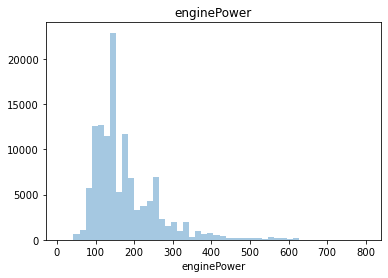

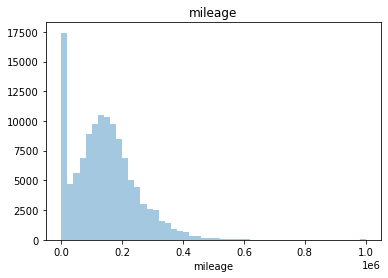

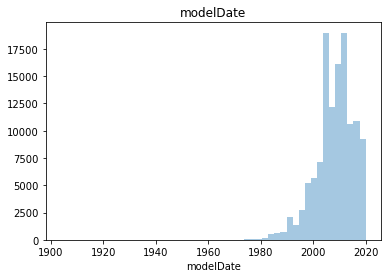

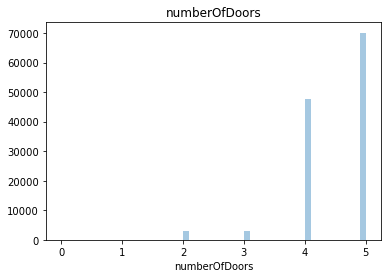

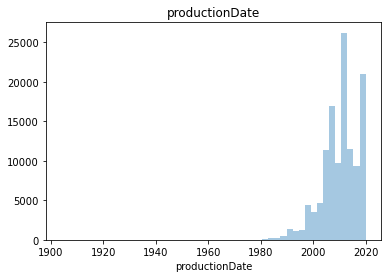

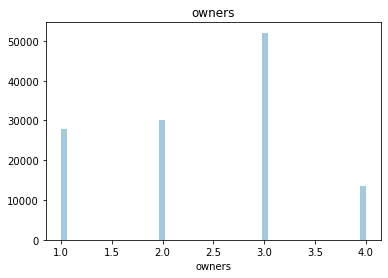

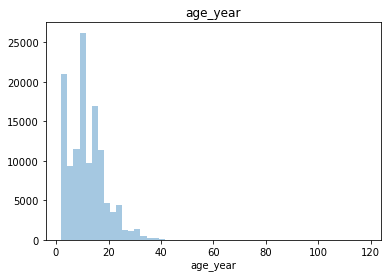

In [39]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Признаки enginePower, mileage имеют правый хвост; признаки modelDate, productionDate - с левым хвостом. Прологарифмируем эти признаки.
Признаки numberOfDoors и owners логарифмировать не имеет смысла.



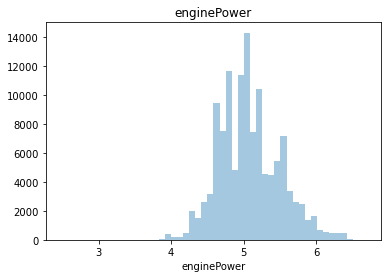

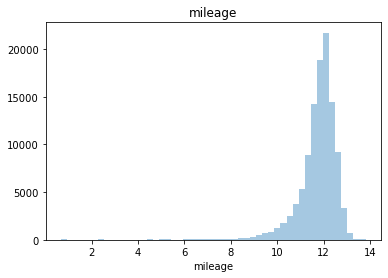

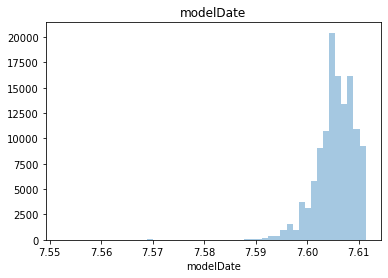

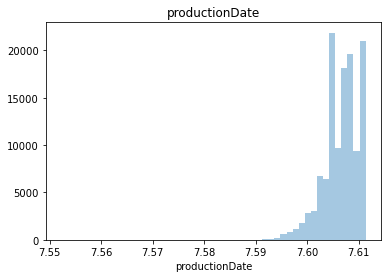

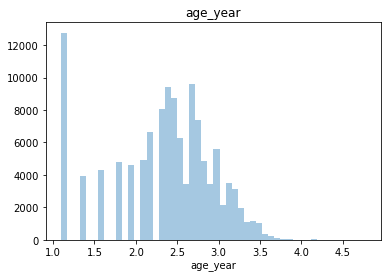

In [40]:
#Логирифмируем переменные и строим новые графики
for i in num_cols:
    if i in ['numberOfDoors','owners']: continue
        
    data[i] = data[i].apply(lambda x: np.log(abs(x)+1))
    plt.figure()
    sns.distplot(data[i][data[i] > 0], kde = False, rug=False)
    plt.title(i)
    plt.show()

Матрица корреляций.

Построим матрицу корреляций между количественными признаками

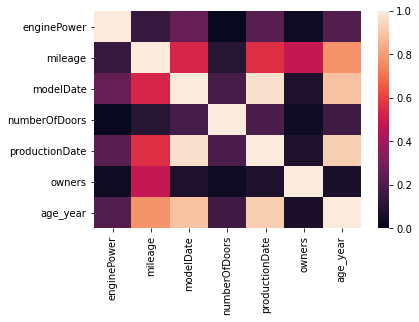

In [41]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Высокая корелляция наблюдается между modelDate и productionDate. Что логично. В идеале один из признаков необходимо удалить, т.к. сильная корреляция может отрицательно сказаться, но в ходе тестов, было выявлено, что удаление одного из признаков снижает значение целевей метрики.

Средняя корреляция наблюдается между mileage и productionDate, mileage и owners. Данные взаимосвязи вполне естественны. Чем больше возраст авто, тем больше у него пробег и количество владельцев.

In [42]:
#Удаление признака отрицательно сказалось на целевой переменной
#data.drop(columns=['productionDate'],inplace=True)
#num_cols.remove('productionDate')

Значимость количественных переменных

Оценим значимость количественных переменных с помощью f_classif.

numberOfDoors      1.945743
owners             9.017836
enginePower       11.964146
productionDate    16.417788
modelDate         16.604874
age_year          34.522461
mileage           87.711088
dtype: float64

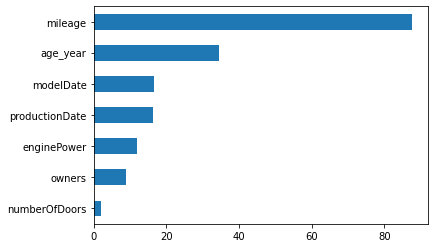

In [43]:
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
display(imp_num)

Судя по отчету, количество дверей слабо влияет на итоговую цену. Можно будет попробовать убрать малозначимый признак при поиске оптимального набора в финальный датасет.

In [44]:
data.drop(columns=['numberOfDoors'],inplace=True)
num_cols.remove('numberOfDoors')

#### 3.3. Поиск и устранение выбросов

Для начала построим боксплоты.

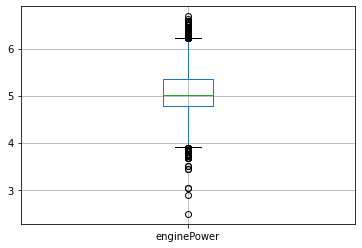

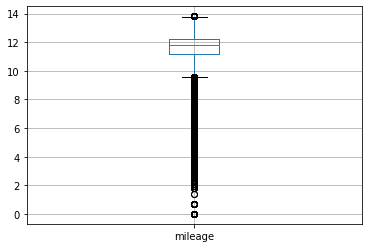

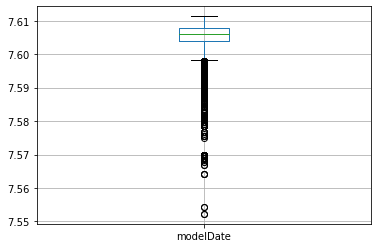

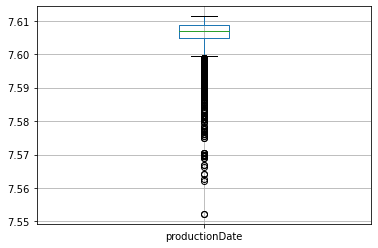

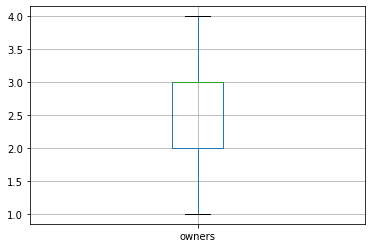

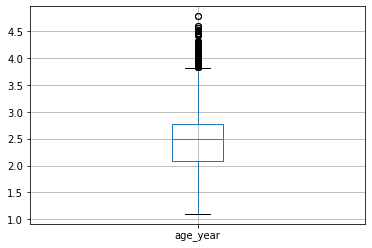

In [45]:
for i in num_cols:
    data[[i]].boxplot()
    plt.show()

Кроме признака owners, все остальные признаки содержат аномалии.

Заменим вылеты в признаках 'age_year','mileage','enginePower' на пограничные значения 1,5 IQR.

In [46]:
for col in ['age_year','mileage','enginePower']:
    #Получаем минимальные и максимальные значения 1,5*IQR
    minimum,maximum = min_max(col)
    
    data[col] = data[col].apply(lambda x: minimum if x < minimum else maximum if x > maximum else x)

Перекодируем признак 'modelDate' в ординальный с разбиением по квартилям 20%, 40%, 60% и 80%.

In [47]:
quantiles = []
for q in [0.2,0.4,0.6,0.8]:
    quantiles.append(data['modelDate'].quantile(q))
    
data['modelDate'] = data['modelDate'].apply(lambda x: 0 if x <= quantiles[0] else 1 if quantiles[0] < x <= quantiles[1] else 
                                                       2 if quantiles[1] < x <= quantiles[2] else 3 if quantiles[2] < x <= quantiles[3] else 4)

Посмотрим на результат

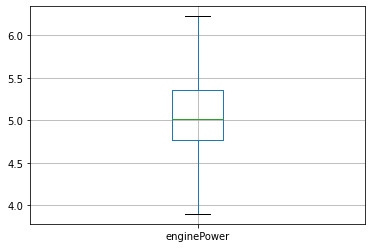

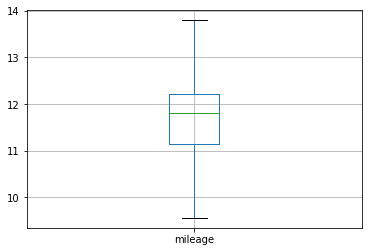

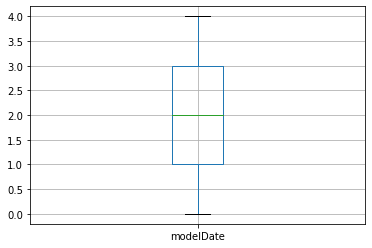

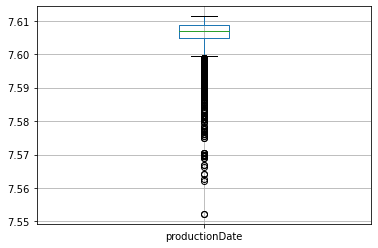

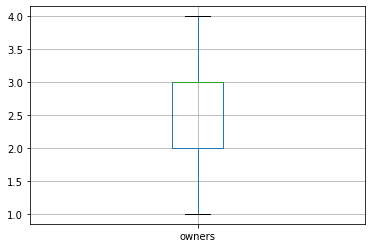

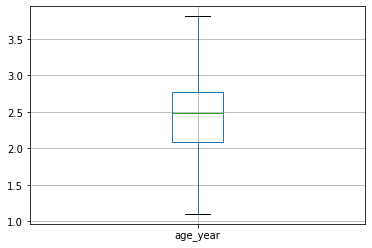

In [48]:
for i in num_cols:
    data[[i]].boxplot()
    plt.show()

#### 3.4. Целевая переменная


Обучающий и валидационный датасет собирались в разное время, соотственно цены на авто должны были измениться. Нет ничего стабильней в мире, чем швейцраский франк. Конвертируем стоимость автомобилей в CHF.

Посмотрим даты сбора данных в валидационном датасете.

In [49]:
valid['parsing_unixtime'].unique()

array(['2020-10-20', '2020-10-19', '2020-10-21', '2020-10-24',
       '2020-10-25', '2020-10-26'], dtype=object)

В обучающем датасете отсутствует метка времени парсинга, но в имени датасета присутствует дата, ее и возьмем 2020-09-09. 
Составим словарь соответствия даты к курсу CHF.

In [50]:
exch_rate = {'2020-10-20': 1/85.3121,'2020-10-19': 1/85.2163, '2020-10-21': 1/85.5455, '2020-10-24': 1/84.4936, '2020-10-25':1/84.4936, \
            '2020-10-26': 1/84.4936, 'NOINFO': 1/82.8041}

data['exch_rate'] = data.parsing_unixtime.apply(lambda x: exch_rate[x])

#Удаляем признак 'parsing_unixtime'. Более он не требуется.
data.drop(columns=['parsing_unixtime'],inplace=True)

Выразим целевую переменную в швейцарских франках, а в сабмишене будем производить обратное преобразование.

In [51]:
y = y*data.query('sample == 1').copy().reset_index()['exch_rate']

Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели.

In [52]:
y = np.log(y)

In [53]:
#Разделяем данные после EDA
X = data.query('sample == 1').drop(['sample','exch_rate'], axis=1)
X = pd.DataFrame(X.to_numpy())

X_sub = data.query('sample == 0').drop(['sample','exch_rate'], axis=1)
X_sub = pd.DataFrame(X_sub.to_numpy())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 4. Построение моделей

## 4.1. Model 1: Наивная модель.

Создадим наивную модель на базе линейной регрессии.

In [54]:
model1 = LinearRegression()
model1.fit(X_train,y_train)

#Предсказываем значения
y_predict = model1.predict(X_test)

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, y_predict))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 5809455.00%


## 4.2. Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   

Для начала опробуем модель CatBoost

In [55]:
# model2 = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model2.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )
# 
# #model2.save_model('catboost_single_model_2_baseline.model')
# 
# y_predict = model2.predict(X_test)
# 
# final_model = model2
# 
# print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_predict)))*100:0.2f}%")

Output: Точность модели по метрике MAPE: 12.36%. 

Показатель на лидерборде при этом 13.41835.

Далее будет использована библиотека lazypredict, которая в качестве целевых метрик выдает только коэффициент детерминации (r2) и среднеквадратичную ошибкку (RMSE). Вычислим RMSE и R2 для CatBoost, чтобы можно было сравнить с остальными моделями.

In [56]:
#print(f"Точность модели по метрике RMSE: {(RMSE(y_test, y_predict,squared=False)):0.2f}")
#print(f"Точность модели по метрике R2: {(r2_score(y_test, y_predict)):0.2f}")

Точность модели по метрике RMSE: 0.19.

Точность модели по метрике R2: 0.97.

Попробуем использовать кросс-валидацию

In [57]:
# model21 = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# 
# final_model = cv(model21,4)
# 
# y_pred = final_model.predict(X_test)
# 
# print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Output: Точность модели по метрике MAPE: 14.23%

На лидерборде результат: 16.03162.

Странно, но кросс-валидация отрицательно сказалась на работе модели.

## 4.3. Оценка моделей с Lazypredict

Воспользуемся библиотекой Lazypredict для оценки эффективности различных моделей. 

Из-за ограничений моей учетной записи на kaggle, не удалось подключить библиотеку непосредственно в ноутбук. Оценка была выполнена на скаченном датасете на домашнем ПК. Ниже представлен код запуска и вывод.

In [58]:
# reg = LazyRegressor(verbose=0,
#                     ignore_warnings=False,
#                     custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# models

![](https://i.ibb.co/DkR6cMF/2022-02-13-17-30-25.png)

Значения метрик R2 и RMSE у тройки лидеров хуже, чем у catboost. Также, стоит отметить, что XGBoost быстрее модели случайного леса и экстремальных деревьев в 9 и 12 раз соотвественно, в случае кросс-валидации работа последних может быть очень затянутой.

## 4.4. Model 3: XGBoost

![](https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png)

Для начала попробуем обучить модель XGBoost с дефолтными параметрами.

In [59]:
# model3 = XGBRegressor()
# 
# model3.fit(X_train,y_train)
# y_pred = model3.predict(X_test)
# 
# print(f"Точность модели XGBoost по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")
# 
# final_model = model3

Output: Точность модели XGBoost по метрике MAPE: 14.28%. 

Показатель на лидерборде при этом 15.48219.

Попробуем подобрать гиперпараметры и использовать KFold.

In [60]:
# model31 = XGBRegressor(
#      objective='reg:squarederror', 
#      colsample_bytree=0.5,               
#      learning_rate=0.05, 
#      max_depth=12, 
#      alpha=1,                   
#      n_estimators=1000,
#      n_jobs=-1,
#  )
# 
# final_model = cv(model31,4)
# 
# y_pred = final_model.predict(X_test)
# 
# print(f"Итоговая точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Output: Итоговая точность модели по метрике MAPE: 12.22%. 

Однако на лидерборде 15.19604.

С кросс-валидацией лучшение есть, но незначительное.

## 4.5. Model 4: RandomForestRegression

<img src="https://laurelindon.com/wp-content/uploads/2010/03/drunken_forest.jpg" width="512" height="384" />

Для начала попробуем обучить модель RandomForestRegression с дефолтными параметрами.

In [61]:
# model4 = RandomForestRegressor(random_state=RANDOM_SEED)
# 
# model4.fit(X_train,y_train)
# y_pred = model4.predict(X_test)
# 
# print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")
# 
# final_model = model4

Output: Точность модели по метрике MAPE: 13.19%. 

На лидерборде 12.25614. Пока это лучший результат.

Подберем гиперпараметры.

In [62]:
# hp.uniform('n_estimators',100,500),
# hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])
# 
# def objective(params):
#     model=RandomForestRegressor(
#          n_estimators=int(params['n_estimators']),
#          max_depth=int(params['max_depth']),
#          min_samples_leaf=int(params['min_samples_leaf']),
#          min_samples_split=int(params['min_samples_split']),
#          bootstrap=params['bootstrap'],
#          max_features=params['max_features'],
#          random_state=RANDOM_SEED,
#          n_jobs=-1
#      )
#     model.fit(X_train, y_train)
#     pred=model.predict(X_test)
#     score=mape(y_test,pred)
#     return score
# 
# def optimize(trial):
#      params={
#          'n_estimators': hp.uniform('n_estimators',100,500),
#          'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#          'max_depth': hp.uniform('max_depth',5,15),
#          'min_samples_split': hp.uniform('min_samples_split',2,10),
#          'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#          'bootstrap': hp.choice("bootstrap", [True, False])
#      }
#      best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.default_rng(RANDOM_SEED))
#      return best
# 
# trial=Trials()
# best=optimize(trial)
# print(best)

Output: 100%|████████████████████████████████████████████| 100/100 [2:16:34<00:00, 81.94s/trial, best loss: 0.0163716985739689]

{'bootstrap': 0, 'max_depth': 14.756826015952033, 'max_features': 0, 'min_samples_leaf': 2.46040557321712, 'min_samples_split': 4.8077965788461565, 'n_estimators': 361.0998089579501}

Создадим модель с подобранными гиперпараметрами и используем K-Fold.

In [63]:
#model41 = RandomForestRegressor(random_state=RANDOM_SEED, bootstrap=0,max_depth=15,max_features='auto',min_samples_leaf=2,min_samples_split=5,n_estimators=360)

#final_model = cv(model41,4)

#y_pred = final_model.predict(X_test)

#print(f"Итоговая точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Output: Итоговая точность модели по метрике MAPE: 15.62%. 

На лидерборде 19.4497. 

Подбор гиперпараметров не принес положительного результата.

## 4.6. Model 5: ExtraTreesRegression

<img src="https://image.krasview.ru/video/eef6f024b3fc5ed/_.jpg" width="640" />

Для начала попробуем обучить модель ExtraTreesRegression с дефолтными параметрами.

In [64]:
# model5 = ExtraTreesRegressor(random_state=RANDOM_SEED)
# 
# model5.fit(X_train,y_train)
# y_pred = model5.predict(X_test)
# 
# print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")
# 
# final_model = model5

Output: Точность модели по метрике MAPE: 13.24%. 

На лидерборде 11.69909. Пока это лучший результат.

Попробуем подобрать гиперпараметры.

In [65]:
#hp.uniform('n_estimators',100,500),
#hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])
#
#def objective(params):
#    model=ExtraTreesRegressor(
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         min_samples_leaf=int(params['min_samples_leaf']),
#         min_samples_split=int(params['min_samples_split']),
#         bootstrap=params['bootstrap'],
#         max_features=params['max_features'],
#         random_state=RANDOM_SEED,
#         n_jobs=-1
#     )
#    model.fit(X_train, y_train)
#    pred=model.predict(X_test)
#    score=mape(y_test,pred)
#    return score
#
#def optimize(trial):
#    params={
#        'n_estimators': hp.uniform('n_estimators',100,500),
#        'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#        'max_depth': hp.uniform('max_depth',5,15),
#        'min_samples_split': hp.uniform('min_samples_split',2,10),
#        'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#        'bootstrap': hp.choice("bootstrap", [True, False])
#    }
#    best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.default_rng(RANDOM_SEED))
#    return best
#
#trial=Trials()
#best=optimize(trial
#print(best)

Output: 100%|██████████████████████████████████████████| 100/100 [4:24:39<00:00, 158.79s/trial, best loss: 0.01633630205242726]

{'bootstrap': 1, 'max_depth': 14.960153651721988, 'max_features': 0, 'min_samples_leaf': 1.820758255341878, 'min_samples_split': 4.778706012598982, 'n_estimators': 345.1454162622641}

Создадим модель ExtraTreesRegressor с подобранными гиперпараметрами и используем K-Fold.

In [66]:
# model51 = ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=1,max_depth=15,max_features='auto',min_samples_leaf=2,min_samples_split=5,n_estimators=350)
# 
# final_model = cv(model51,4)
# 
# y_pred = final_model.predict(X_test)
# 
# print(f"Итоговая точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Output: Итоговая точность модели по метрике MAPE: 14.62%. 

На лидерборде 17.03249.

Полученные гиперпаметры не улучшили работу модели. Вероятно, дело в параметре максимальной глубины.

## 4.7. Model 6: Стекинг

<img src="https://www.rightthisminute.com/sites/default/files/styles/blog_detail_page_hero/public/posts/thumbails/husky_biscuits.jpg" width="640" />

Лучше всего проявили себя две модели: RandomForestRegression и ExtraTreesRegression с параметрами по умолчанию.

Попробуем стекинг этих моделей с для улучшения целевой метрики, обобщающей моделью будет линейная регрессия.

In [67]:
# models_6 = (
#           ('RandForRegr',RandomForestRegressor(random_state=RANDOM_SEED)),\
#           ('ExtrTreeRegr',ExtraTreesRegressor(random_state=RANDOM_SEED))\
# )
# meta_model6 = LinearRegression()
# 
# model61 = StackingRegressor(estimators=models_6, final_estimator=meta_model6)
# 
# model61.fit(X_train,y_train)
# 
# y_pred = model61.predict(X_test)
# 
# final_model = model61
# 
# print(f"Итоговая точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Output: Итоговая точность модели по метрике MAPE: 12.86%

На лидерборде 11.52073.

Стекинг 2 моделей дал наилучший результат.

## 4.8. Final Model.

Лучшим алгоритмом стал стекинг из моделей случайного леса и экстремальных деревьев с обобщающей моделью линейной регрессии.

В ходе разведывательного анализа было принято решение об ограничении количества моделей для включения в итоговый датасет. Вошло топ-150 моделей.

> 
> top_models = data['model_name'].value_counts().index.values.tolist()[:150]
> 

Для финальной попытки возьмем датасет без этого ограничения (все модели). Это значительно увеличит время обучение модели, но должно принести более высокий результат.

In [68]:
models_7 = (
          ('RandForRegr',RandomForestRegressor(random_state=RANDOM_SEED)),\
          ('ExtrTreeRegr',ExtraTreesRegressor(random_state=RANDOM_SEED))\
)
meta_model7 = LinearRegression()

model71 = StackingRegressor(estimators=models_7, final_estimator=meta_model7, n_jobs=2, cv=4)

model71.fit(X_train,y_train)

y_pred = model71.predict(X_test)

final_model = model71

print(f"Итоговая точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Итоговая точность модели по метрике MAPE: 12.79%


Output: Итоговая точность модели по метрике MAPE: 12.79%

Лидерборд: 11.43028

Результат 11.434028 - лучший, которого удалось достичь.

# Submission

In [69]:
#Записываем значения для сабмишена
y_valid = np.exp(final_model.predict(X_sub))
#Преобразуем обратно CHF->RUB
y_valid = y_valid/data.query('sample == 0')['exch_rate']

predict_submission = y_valid

In [70]:
sample_submission['price'] = predict_submission
#sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.786743e+05
1,1100549428,9.333151e+05
2,1100658222,8.991723e+05
3,1100937408,6.971999e+05
4,1101037972,6.640893e+05
5,1100912634,6.937853e+05
6,1101228730,6.047455e+05
7,1100165896,3.868159e+05
8,1100768262,1.603346e+06
9,1101218501,7.052756e+05


# Заключение

В ходе выполнения задания была создана модель предсказания стоимости автомобиля по его характеристикам.

Лучшим из рассмотренных себя проявил стекинг-алгоритм моделей случайного леса и экстремальных деревьев с обобщающей моделью линейной регрессии.

При наличии бОльшего запаса времени интересно было бы попробовать в стекинге классификаторы (с таргетом ценовой категории "дешевый", "средний", ... , "эксклюзив"), а также кластеризацию.